In [1]:
import scanpy as sc
import gseapy as gp
from collections import defaultdict
import pandas as pd
import re 
import numpy as np

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ‘GO_Biological_Process_2021’ is a pre‑compiled, human‑gene library
go_bp_dict = gp.get_library(name='GO_Biological_Process_2021', organism='Human')
# └─ returns { 'GO_TERM_NAME': [gene1, gene2, …], ... }


In [50]:
cancer = "ovarian"
xenium_folder_dict = {"lung": "Xenium_Prime_Human_Lung_Cancer_FFPE_outs",
                        "breast":"Xenium_Prime_Breast_Cancer_FFPE_outs",
                        "lymph_node": "Xenium_Prime_Human_Lymph_Node_Reactive_FFPE_outs",
                        "prostate": "Xenium_Prime_Human_Prostate_FFPE_outs",
                        "skin": "Xenium_Prime_Human_Skin_FFPE_outs",
                        "ovarian": "Xenium_Prime_Ovarian_Cancer_FFPE_outs",
                        "cervical": "Xenium_Prime_Cervical_Cancer_FFPE_outs"
                        }

xenium_folder = xenium_folder_dict[cancer]
adata_path = f"/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/public_data/10x_genomics/{xenium_folder}/preprocessed/fine_tune_refined_v2/processed_xenium_data_fine_tune_refined_v2_annotated.h5ad"
adata = sc.read_h5ad(adata_path)

In [51]:
# 1) restrict to genes present in your AnnData
genes_in_data = set(adata.var_names)            # adata already loaded

clean_go_terms = {}
min_size, max_size = 10, 300                    # tweak as you wish

for term, gene_list in go_bp_dict.items():
    overlap = genes_in_data.intersection(gene_list)
    if min_size <= len(overlap) <= max_size:
        clean_go_terms[term] = list(overlap)


In [52]:
for term, genes in clean_go_terms.items():
    sc.tl.score_genes(
        adata,
        gene_list = genes,
        score_name = f"score_{term.replace(' ', '_')}",
        use_raw    = False          # or False depending on your AnnData
    )


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_score_genes.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_score_genes.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_score_genes.py:176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

In [53]:
score_cols = [c for c in adata.obs.columns if c.startswith("score_")]
scores     = adata.obs[score_cols]

k = 5
top_terms_per_cell = scores.apply(
    lambda row: row.nlargest(k).index.str.replace("score_", "").tolist(),
    axis=1
)

In [54]:
# Extract the top GO term (rank 1) per cell
adata.obs["top1_go_term"] = top_terms_per_cell.apply(lambda x: x[0] if len(x) > 0 else "None")


/tmp/ipykernel_680/2122218222.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs["top1_go_term"] = top_terms_per_cell.apply(lambda x: x[0] if len(x) > 0 else "None")


In [55]:
def pretty_go(name):
    name = name.replace("score_", "")
    name = re.sub(r"\(go:\d+\)$", "", name, flags=re.I)
    name = name.replace("'", "").replace('"', "")
    name = re.sub(r"_+", " ", name).strip()
    return name

adata.obs["top1_go_term_pretty"] = adata.obs["top1_go_term"].astype(str).map(pretty_go)


/tmp/ipykernel_680/2077476871.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs["top1_go_term_pretty"] = adata.obs["top1_go_term"].astype(str).map(pretty_go)


In [56]:
go_sentences = top_terms_per_cell.apply(lambda terms: ", ".join(pretty_go(t) for t in terms))
adata.obs["go_sentence"] = go_sentences


/tmp/ipykernel_680/1204295723.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs["go_sentence"] = go_sentences


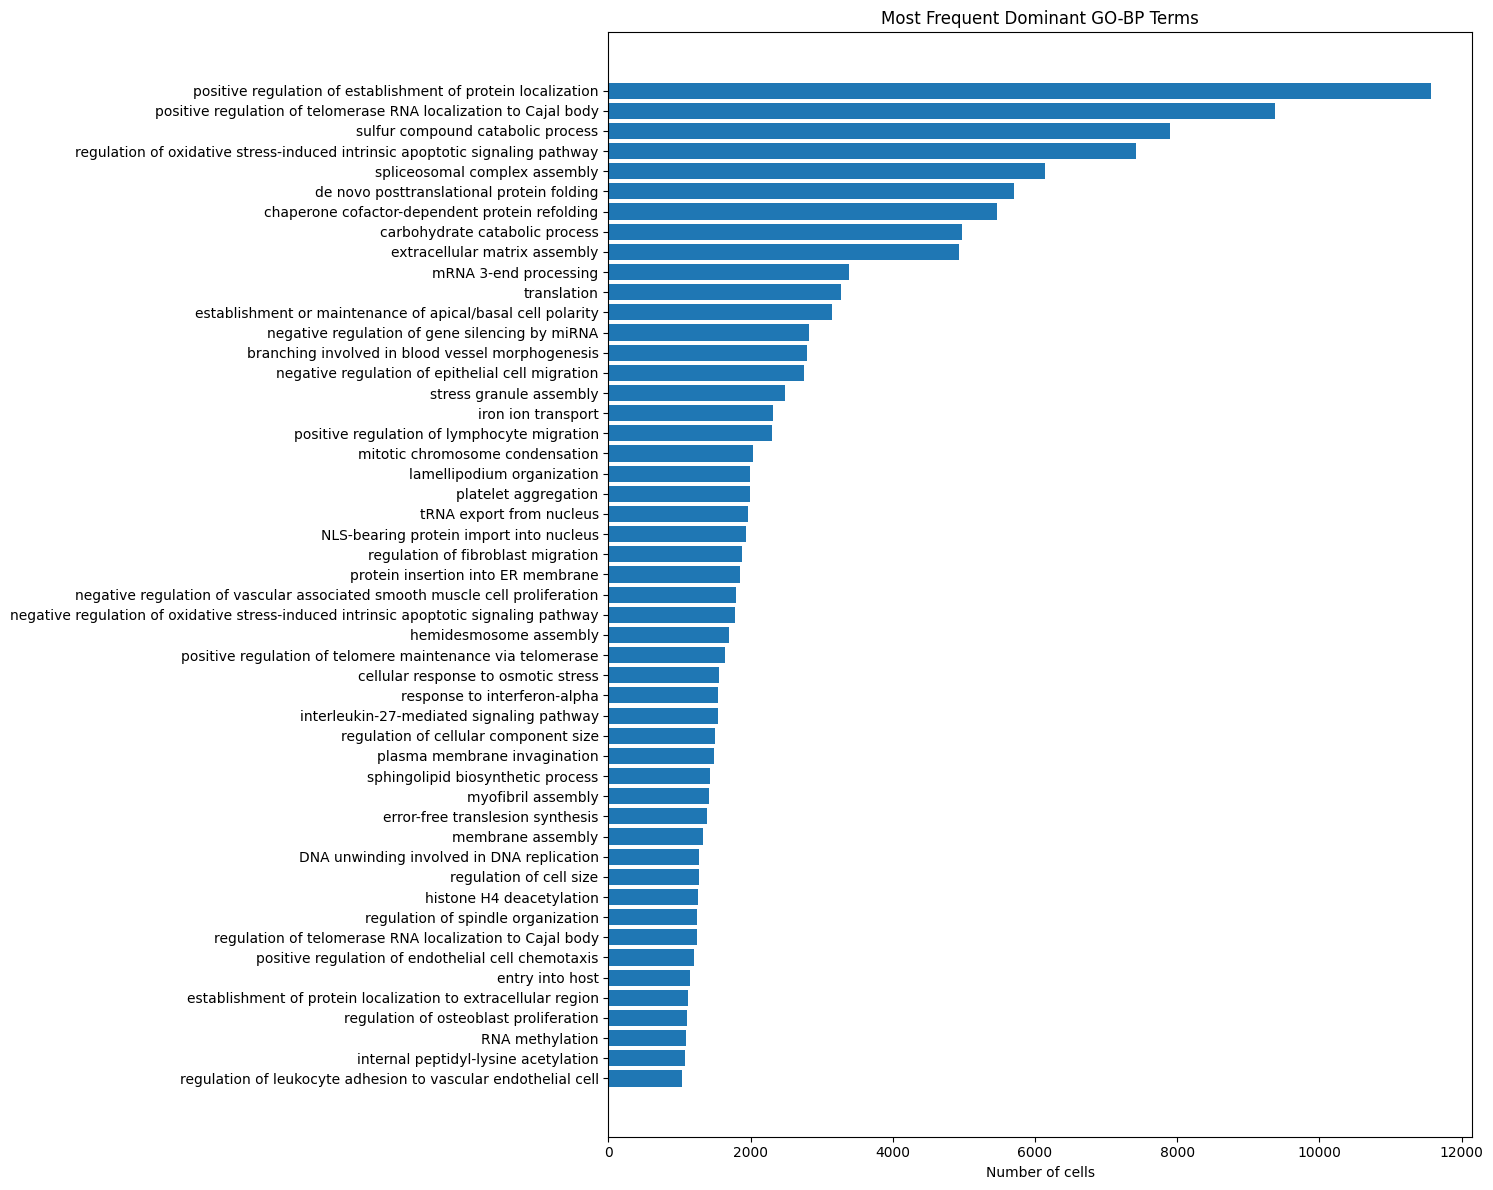

In [57]:

term_counts = Counter(adata.obs["top1_go_term"])
top_terms, freqs = zip(*term_counts.most_common(50))

plt.figure(figsize=(15,12))
plt.barh([pretty_go(t) for t in top_terms], freqs)
plt.gca().invert_yaxis()
plt.xlabel("Number of cells")
plt.title("Most Frequent Dominant GO-BP Terms")
plt.tight_layout()
plt.show()


Top 5 GO terms: ['positive_regulation_of_establishment_of_protein_localization_(GO:1904951)', 'positive_regulation_of_telomerase_RNA_localization_to_Cajal_body_(GO:1904874)', 'sulfur_compound_catabolic_process_(GO:0044273)', 'regulation_of_oxidative_stress-induced_intrinsic_apoptotic_signaling_pathway_(GO:1902175)', 'spliceosomal_complex_assembly_(GO:0000245)']


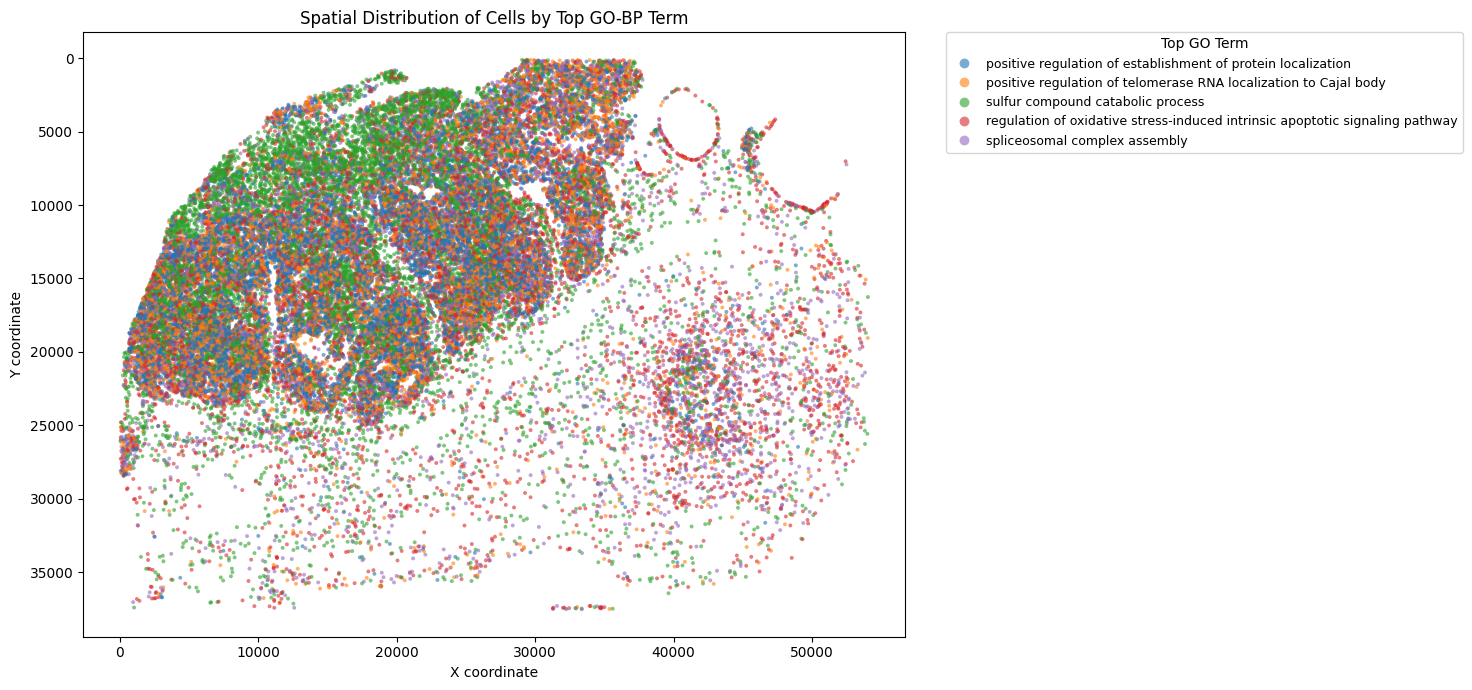

In [58]:

top5 = Counter(adata.obs["top1_go_term"]).most_common(5)
top5_terms = [t[0] for t in top5]
print("Top 5 GO terms:", top5_terms)

subset = adata.obs[adata.obs["top1_go_term"].isin(top5_terms)].copy()
subset["top1_go_term_pretty"] = pd.Categorical(
    subset["top1_go_term"].map(pretty_go),
    categories=[pretty_go(t) for t in top5_terms],  # ensure only top 5 in order
    ordered=True
)

plt.figure(figsize=(15, 7))
ax = sns.scatterplot(
    data=subset,
    x="x_centroid",
    y="y_centroid",
    hue="top1_go_term_pretty",
    s=8,                # point size
    linewidth=0,
    alpha=0.6,
    palette="tab10"     # or "Set2", "Paired", etc.
)
plt.gca().invert_yaxis()  # optional for histology-style orientation
plt.title("Spatial Distribution of Cells by Top GO-BP Term")
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    handles=handles, labels=labels,       # skip automatic 'hue' title
    title="Top GO Term",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    markerscale=2.5,     # <--- increase legend dot size
    fontsize=9,
    title_fontsize=10
)
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.tight_layout()
plt.show()


In [59]:
# Convert to DataFrame and name columns
go_sentences_df = go_sentences.to_frame(name="go_sentences")  # Name the values column
go_sentences_df.index.name = "cell_id"                   # Name the index

# Save to CSV
go_sentences_df.to_csv(f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/gene_ontology/{xenium_folder.replace('outs', 'GO.csv')}", index = True)

In [60]:
pd.read_csv(f"/rsrch9/home/plm/idso_fa1_pathology/TIER2/paul-xenium/gene_ontology/{xenium_folder.replace('outs', 'GO.csv')}", index_col="cell_id")

,go_sentences
cell_id,
aaaaebmm-1,"regulation of protein export from nucleus, gly..."
aaaafhpp-1,"mRNA 3-end processing, mRNA metabolic process,..."
aaaakeoi-1,regulation of proteolysis involved in cellular...
aaaalald-1,"regulation of neuroblast proliferation, regula..."
aaaalomf-1,positive regulation of telomere maintenance vi...
...,...
oiipoind-1,"positive regulation of type 2 immune response,..."
oiipojad-1,"glycosaminoglycan biosynthetic process, glycos..."
oijalnnk-1,cell migration involved in sprouting angiogene...


cell_id
aaaaadnb-1    negative regulation of interleukin-2 productio...
aaaabalp-1    IRE1-mediated unfolded protein response, regul...
aaaadfei-1    cellular response to interferon-beta, regulati...
aaaadjia-1    regulation of cellular amine metabolic process...
aaaafglb-1    RNA destabilization, regulation of supramolecu...
                                    ...                        
oikijpja-1    regulation of filopodium assembly, regulation ...
oikioede-1    negative regulation of NIK/NF-kappaB signaling...
oikiokmm-1    regulation of amyloid-beta clearance, transiti...
oikjekcf-1    regulation of exit from mitosis, posttranscrip...
oikjhded-1    regulation of cellular amide metabolic process...
Length: 244659, dtype: object

In [ ]:
cancer